<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Visualize-Ground-Truth" data-toc-modified-id="Visualize-Ground-Truth-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Visualize Ground Truth</a></span><ul class="toc-item"><li><span><a href="#JRDB" data-toc-modified-id="JRDB-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>JRDB</a></span><ul class="toc-item"><li><span><a href="#Overview" data-toc-modified-id="Overview-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Overview</a></span></li><li><span><a href="#Evaluate-Detections" data-toc-modified-id="Evaluate-Detections-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Evaluate Detections</a></span></li></ul></li></ul></li><li><span><a href="#BEV-Plot" data-toc-modified-id="BEV-Plot-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>BEV Plot</a></span></li><li><span><a href="#Test" data-toc-modified-id="Test-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Test</a></span></li></ul></div>

Followed this [instruction manual](https://github.com/kuixu/kitti_object_vis/tree/master/jupyter) on how to setup jupyter notebook mayavi interface for remote usage.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from xvfbwrapper import Xvfb
vdisplay = Xvfb(width=1920, height=1080)
vdisplay.start()

In [3]:
from mayavi import mlab
mlab.init_notebook('ipy')

Notebook initialized with ipy backend.


In [24]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

import visualize_utils as V
from pcdet.utils.custom_data_utils import load_h5, load_h5_basic, get_data_files
from pcdet.utils.object3d_custom import Object3d
from pcdet.utils.box_utils import boxes_to_corners_3d
from pcdet.ops.iou3d_nms import iou3d_nms_utils

In [5]:
print(os.getcwd())

/home/crowdbot/master_lara/OpenPCDet/tools/visual_utils


# Visualize Ground Truth 

## JRDB 

In [6]:
from pcdet.utils.jrdb_utils import transform_pts_upper_velodyne_to_base, transform_pts_laser_to_base,\
                                   transform_pts_lower_velodyne_to_base, transform_pts_lower_to_upper_velodyne
from pcdet.datasets.augmentor import augmentor_utils as aug
from pcdet.utils import plot_utils

### Overview

In [7]:
FILE_PATH = os.path.join('../../', 'data/jrdb/')
DATA_PATH = '/hdd/master_lara_data/JRDB/cvgl/group/jrdb/data'
LABEL_PATH = os.path.join(DATA_PATH, 'train_dataset', 'labels', 'labels_3d')
OUTPUT_PATH = os.path.join('../../', 'output/kitti_models/pointrcnn/') # model detections 

In [8]:
def get_lidar_pts(idx): 
    if  type(idx) == int: # idx 
        all_val_files = get_data_files(os.path.join(FILE_PATH, 'val.txt'))
        lidar_file_upper = DATA_PATH + all_val_files[idx]
        print(lidar_file_upper)
    elif type(idx) == str: 
        lidar_file_upper = idx # filename
    lidar_file_lower = lidar_file_upper.replace('upper', 'lower') 
    
    pts_upper = np.array(load_h5_basic(lidar_file_upper), dtype=np.float32)
    pts_upper[:,:3] = transform_pts_upper_velodyne_to_base(pts_upper[:, 0:3].T).T

    pts_lower = np.array(load_h5_basic(lidar_file_lower), dtype=np.float32)
    pts_lower[:,:3] = transform_pts_lower_velodyne_to_base(pts_lower[:, 0:3].T).T

    pts_merged = np.concatenate((pts_upper, pts_lower), axis=0)
    return pts_merged

In [9]:
def load_json_file(label_file):
    """ Loads json file to a python dictionary.

    Args:
        label_file: full file path to json file

    Returns:
        dictionary contained in json file 
    """
    with open(label_file) as f:
        data = json.load(f)
    return data 

In [10]:
import collections
import json
def get_all_labels(label_dir): 
    label_dict = collections.defaultdict(dict)   
    all_instances = 0 
    no_eval_ct = 0 
    interpolated_ct = 0 
    num_points_small = 0 
    for json_file in os.listdir(label_dir): 
        sequence = os.path.basename(os.path.splitext(json_file)[0])
        file_dict = load_json_file(os.path.join(label_dir, json_file))
        for frame, annotations_list in file_dict['labels'].items(): 
            frame_num = frame.split('.')[0]
            box_list = []
            for anno in annotations_list: 
                all_instances +=1
                no_eval = anno['attributes']['no_eval']
                if no_eval: no_eval_ct+=1
                interpolated = anno['attributes']['interpolated']
                if interpolated: interpolated_ct += 1
                if anno['attributes']['num_points']<=5: 
                    num_points_small += 0
                if not no_eval: 
                    box_dict = anno['box']
                    xyz = np.array([box_dict["cx"], box_dict["cy"], box_dict["cz"]], dtype=np.float32).reshape(1, 3)
                    lwh = np.array([box_dict["l"], box_dict["w"], box_dict["h"]], dtype=np.float32).reshape(1, 3)
                    box = np.concatenate([xyz, lwh, np.reshape(box_dict['rot_z'], (-1,1))], axis=1)
                    box_list.append(box)
            label_dict[sequence][frame_num] = box_list 
#             label_dict[sequence]
    print(all_instances, no_eval_ct, interpolated_ct, num_points_small)
    return label_dict 

In [11]:
def get_label(frame, label_dict, box_object=False):
    """ 
    Return bbox annotations per frame, defined as (N,7), i.e. (N x [x, y, z, h, w, l, ry])

    Args:
        frame (string): frame id 
    """
    file_parts = frame.split('/')
    sequence = file_parts[len(file_parts)-2]   
    frame_num = file_parts[-1].split('.')[0]
    print('Sequence: {}, Frame: {}'.format(sequence, frame_num))
    try: 
        bbox_list = np.reshape(label_dict[sequence][frame_num],(-1,7)) 
    except KeyError: 
        print("Label dict does not contain key combination (seq: {}, frame_num: {})".format(sequence, frame_num))
        return None
    if box_object: 
        bbox_obj_list = [Object3d(box, gt=True) for box in bbox_list]
        return bbox_obj_list
    else: 
        return bbox_list 

In [12]:
print(LABEL_PATH)
label_dict = get_all_labels(LABEL_PATH)
print(label_dict.__len__())

/hdd/master_lara_data/JRDB/cvgl/group/jrdb/data/train_dataset/labels/labels_3d
862501 79566 860797 0
27


In [13]:
def visualize_pts(pts, fig=None, bgcolor=(0, 0, 0), color=(1.0, 1.0, 1.0),
                  show_intensity=False, size=(600, 600), draw_origin=True):
    if not isinstance(pts, np.ndarray):
        pts = pts.cpu().numpy()
    if fig is None:
        fig = mlab.figure(figure=None, bgcolor=bgcolor, engine=None, size=size)

    if show_intensity:
        G = mlab.points3d(pts[:, 0], pts[:, 1], pts[:, 2], pts[:, 3], mode='point',
                          colormap='gnuplot', scale_factor=1, figure=fig)
    else:
        G = mlab.points3d(pts[:, 0], pts[:, 1], pts[:, 2], mode='point',
                          color=color, scale_factor=1, figure=fig)
    if draw_origin:
        mlab.points3d(0, 0, 0, color=(1, 1, 1), mode='cube', scale_factor=0.2)
        mlab.plot3d([0, 1.0], [0, 0], [0, 0], color=(1, 0, 0), tube_radius=0.025)
        mlab.plot3d([0, 0], [0, 1.0], [0, 0], color=(0, 1, 0), tube_radius=0.025)
        mlab.plot3d([0, 0], [0, 0], [0, 1.0], color=(0, 0, 1), tube_radius=0.025)

    return fig


In [17]:
def get_lidar_pts_from_file(f): 
    print("Loading data from: {}".format(f))
    f1 = f.replace('upper', 'lower') 
    
    pts_upper = np.array(load_h5_basic(f), dtype=np.float32)
    pts_upper[:,:3] = transform_pts_upper_velodyne_to_base(pts_upper[:, 0:3].T).T
#     pts_upper_trans = np.hstack((pts_coor_upper, pts_upper[:,3, np.newaxis]))

    pts_lower = np.array(load_h5_basic(f1), dtype=np.float32)
    pts_lower[:,:3] = transform_pts_lower_velodyne_to_base(pts_lower[:, 0:3].T).T
    # pts_coor_lower = transform_pts_lower_to_upper_velodyne(pts_lower[:, 0:3].T).T
#     pts_lower_trans = np.hstack((pts_coor_lower, pts_lower[:,3, np.newaxis]))

#     pts_merged = np.concatenate((pts_upper_trans, pts_lower_trans), axis=0)  
    # pts_merged = np.concatenate((pts_upper, pts_lower_trans), axis=0)  
    return pts_lower, pts_upper

In [18]:
f = '/hdd/master_lara_data/JRDB/cvgl/group/jrdb/data/train_dataset/pointclouds/hdf5/upper_velodyne/jordan-hall-2019-04-22_0/000012.h5'                                                                                                                                                                                                                                              
pts_coor_lower, pts_coor_upper = get_lidar_pts_from_file(f)
gt_boxes = get_label(f, label_dict)
gt_corners3d = boxes_to_corners_3d(gt_boxes, rot_mat_alt=True)
print('Num ground truth objects: {}'.format(gt_boxes.shape[0]))
fig = None
fig = visualize_pts(pts_coor_upper, bgcolor=(0,0,0), color=(0.0, 1.0, 0.0), show_intensity=False, size=(1000,600)) # green
fig = visualize_pts(pts_coor_lower, fig=fig, bgcolor=(0,0,0), color=(1.0, 0.0, 0.0), show_intensity=False, size=(1000,600)) # red 
fig = V.draw_corners3d(gt_corners3d, fig=fig, color=(0, 0, 1), max_num=100)

Loading data from: /hdd/master_lara_data/JRDB/cvgl/group/jrdb/data/train_dataset/pointclouds/hdf5/upper_velodyne/jordan-hall-2019-04-22_0/000012.h5
Sequence: jordan-hall-2019-04-22_0, Frame: 000012
Num ground truth objects: 7


In [19]:
fig

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03\xe8\x00\x00\x02X\x08\x02\x00\x00\x00~|[r\x00\x00…

In [181]:
name = 'jrdb_test_plot_lidar_setup_scene1_2'
mlab.savefig(filename=os.path.join('../../','plots/{}.png'.format(name)))

### Evaluate Detections

In [20]:
def read_annotations(label_path):    
    with open(label_path, 'r') as f:
        lines = f.readlines()
    content = [line.strip().split(' ') for line in lines]
    bboxes = np.vstack(
        [np.array((float(det[2]), float(det[3]), float(det[4]), # x,y,z
                   float(det[6]), float(det[7]), float(det[5]), # w,l,h
                   float(det[8])), dtype=np.float32) for det in content]) # rz
    return bboxes

In [67]:
def evaluate_detections(idx, epoch, experiment, val_tag):
    all_val_files = get_data_files(os.path.join(FILE_PATH, 'val.txt'))
    print('Total number of evaluation instances: {}'.format(len(all_val_files)))
    frame_file = os.path.join(DATA_PATH, all_val_files[idx])
    
    pts_lidar = get_lidar_pts(idx)
    gt_boxes = get_label(frame_file, label_dict)

    bboxes3d_path = os.path.join(OUTPUT_PATH, "{}/eval/epoch_{}/val/{}/final_result/data/{}.txt".format(experiment, epoch,val_tag, idx))
    print('Ground Truth Boxes: \n - path: {}\n - shape: {}'.format(frame_file, gt_boxes.shape))
        
    det_boxes = read_annotations(bboxes3d_path)
    print('Det_Boxes: \n - path: {}\n - shape: {}'.format(bboxes3d_path, det_boxes.shape))
    
    fig = V.draw_scenes(pts_lidar, gt_boxes=gt_boxes, ref_boxes=det_boxes, ref_scores=None, ref_labels=None)
    _plot_sequence(pts_lidar, gt_boxes, idx, det_boxes=det_boxes, image=None, show_intensity=False, save_fig=False)
    
    return fig

In [22]:
idx = 2000
epoch = 80
experiment = 'l1_corner_loss_80epochs'
val_tag = 'jrdb'
fig = evaluate_detections(idx, epoch, experiment, val_tag)

Total number of evaluation instances: 6203
/hdd/master_lara_data/JRDB/cvgl/group/jrdb/data/train_dataset/pointclouds/hdf5/upper_velodyne/huang-2-2019-01-25_0/000456.h5
Sequence: huang-2-2019-01-25_0, Frame: 000456
Ground Truth Boxes: 
 - path: /train_dataset/pointclouds/hdf5/upper_velodyne/huang-2-2019-01-25_0/000456.h5
 - shape: (9, 7)
Det_Boxes: 
 - path: ../../output/kitti_models/pointrcnn/l1_corner_loss_80epochs/eval/epoch_80/val/jrdb/final_result/data/2000.txt
 - shape: (2, 7)


In [56]:
idx = 1000
epoch = 30
experiment = 'jrdb_exp5'
val_tag = 'jrdb'
fig = evaluate_detections(idx, epoch, experiment, val_tag)

Total number of evaluation instances: 6203
/hdd/master_lara_data/JRDB/cvgl/group/jrdb/data/train_dataset/pointclouds/hdf5/upper_velodyne/clark-center-2019-02-28_1/000995.h5
Sequence: clark-center-2019-02-28_1, Frame: 000995
Ground Truth Boxes: 
 - path: /train_dataset/pointclouds/hdf5/upper_velodyne/clark-center-2019-02-28_1/000995.h5
 - shape: (30, 7)
Det_Boxes: 
 - path: ../../output/kitti_models/pointrcnn/jrdb_exp5/eval/epoch_30/val/jrdb/final_result/data/1000.txt
 - shape: (8, 7)


In [57]:
fig

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03\xe8\x00\x00\x02X\x08\x02\x00\x00\x00~|[r\x00\x00…

In [82]:
name = '{}_{}_epoch{}_idx{}_bad_ex'.format(experiment, val_tag, epoch, idx)
mlab.savefig(filename=os.path.join('../../','plots/{}.png'.format(name)))

Total number of evaluation instances: 6203
/hdd/master_lara_data/JRDB/cvgl/group/jrdb/data/train_dataset/pointclouds/hdf5/upper_velodyne/clark-center-2019-02-28_1/000995.h5
Sequence: clark-center-2019-02-28_1, Frame: 000995
Ground Truth Boxes: 
 - path: /train_dataset/pointclouds/hdf5/upper_velodyne/clark-center-2019-02-28_1/000995.h5
 - shape: (30, 7)
Det_Boxes: 
 - path: ../../output/kitti_models/pointrcnn/jrdb_exp9_no_aug/eval/epoch_27/val/jrdb/final_result/data/1000.txt
 - shape: (9, 7)
Did not save figure. Add filename in arguments to be able to save figure.


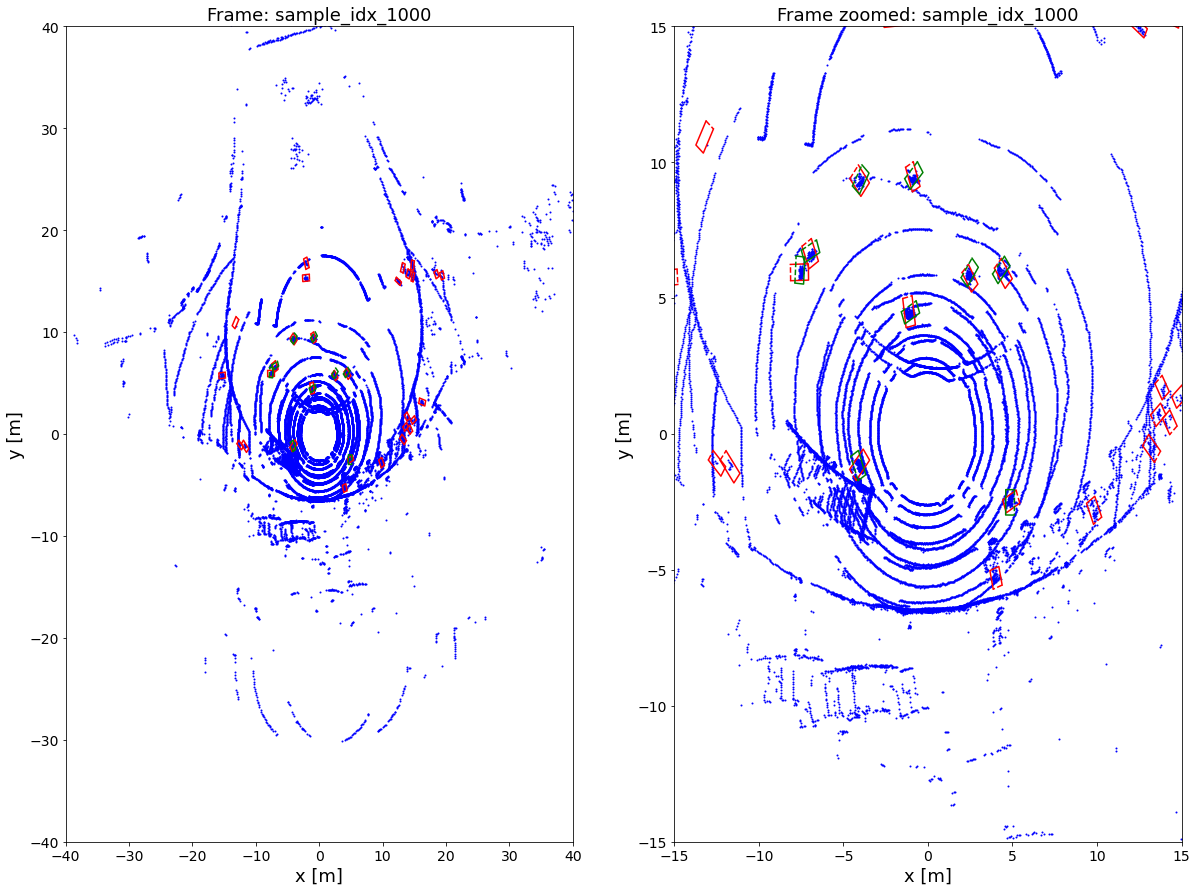

In [84]:
idx = 1000
epoch = 27
experiment = 'jrdb_exp9_no_aug'
val_tag = 'jrdb'
fig2 = evaluate_detections(idx, epoch, experiment, val_tag)

In [59]:
fig2

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03\xe8\x00\x00\x02X\x08\x02\x00\x00\x00~|[r\x00\x00…

In [ ]:
_T_camera_to_base = np.array([0.019685, 0, -0.742092], dtype=np.float32).reshape(1, 3)
_T_upper_lidar_to_base = np.array([0.019685, 0, -1.077382], dtype=np.float32).reshape(1, 3) # from calib file, actually to rgb 
_T_camera_to_upper_lidar = np.array([0,0,1.077382-0.742092], dtype=np.float32).reshape(1, 3)


In [32]:
def get_tp_mask_from_overlaps(pred_boxes, gt_boxes): 
    iou_thresholds = np.arange(0.3, 0.9, 0.05)
    pred_boxes = torch.from_numpy(pred_boxes).contiguous().cuda(non_blocking=True).float()
    gt_boxes = torch.from_numpy(gt_boxes).contiguous().cuda(non_blocking=True).float()
    iou3d = iou3d_nms_utils.boxes_iou3d_gpu(pred_boxes, gt_boxes)  # (M, N)
    max_iou, gt_ind  = torch.max(iou3d, dim=1) # max_overlaps, gt_assignment

    mask_dict = {}
    for iou in iou_thresholds: 
        assigned_gt_box_idx = []
        true_positive_mask = []
        for el in zip(max_iou,gt_ind): 
            if el[0].item() > iou and el[1].item() not in assigned_gt_box_idx: 
                true_positive_mask.append(1.0)
            else: 
                true_positive_mask.append(0.0)
            
        true_positive_mask = (max_iou > iou).float().cpu().numpy()
        mask_dict[iou] = true_positive_mask
    return mask_dict

In [26]:
det_boxes, gt_boxes = evaluate_detections(idx, epoch, experiment, val_tag)

Total number of evaluation instances: 6203
/hdd/master_lara_data/JRDB/cvgl/group/jrdb/data/train_dataset/pointclouds/hdf5/upper_velodyne/huang-2-2019-01-25_0/000456.h5
Sequence: huang-2-2019-01-25_0, Frame: 000456
Ground Truth Boxes: 
 - path: /train_dataset/pointclouds/hdf5/upper_velodyne/huang-2-2019-01-25_0/000456.h5
 - shape: (9, 7)
Det_Boxes: 
 - path: ../../output/kitti_models/pointrcnn/l1_corner_loss_80epochs/eval/epoch_80/val/jrdb/final_result/data/2000.txt
 - shape: (2, 7)


# BEV Plot

In [24]:
split = 'train'
IM_PATH = os.path.join(DATA_PATH, f'{split}_dataset/images/image_stitched')

In [60]:
import cv2
def _load_image(file):
    """Load an image given file url.

    Returns:
        im (np.ndarray[H, W, 3]): (H, W) = (480, 3760) for stitched image,
            (480, 752) for individual image
    """
    assert os.path.exists(file)
    im = cv2.imread(file, cv2.IMREAD_COLOR)
    im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
    return im

def get_image(file): 
    file_parts = file.split('/')
    sequence = file_parts[len(file_parts)-2]   
    frame_num = file_parts[-1].split('.')[0]
    return _load_image(os.path.join(IM_PATH, sequence, frame_num+'.jpg'))

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def draw_bev(corners, ax, c="red"):
    # side and back boarder
    xy = corners[[0,3, 2,1],:2]
    ax.plot(xy[:,0], xy[:,1], c=c, linestyle="-")
    # front boarder
    xy = corners[[0, 1], :2]
    ax.plot(xy[:,0], xy[:,1], c=c, linestyle="--")

def _plot_sequence(pts_lidar,  gt_boxes, frame, det_boxes=None, image=None, show_intensity=False, save_fig=False):
#     fig,ax_bev = plt.subplots(figsize=(20, 10))
    plt.rc('xtick',labelsize=14)
    plt.rc('ytick',labelsize=14)
    fig = plt.figure(figsize=(20, 15))
    if image is None: 
        gs = GridSpec(1, 2, figure=fig)
    else: 
        # image
        gs = GridSpec(2, 2, figure=fig)
        ax_im = fig.add_subplot(gs[1, :])
        ax_im.cla()
        ax_im.axis("off")
        ax_im.imshow(image)
#     gs.update(wspace=0.0, hspace=0.0)
    ax_bev = fig.add_subplot(gs[0, 0])
    ax_bev_zoom = fig.add_subplot(gs[0, 1])
    
    color_pool = np.random.uniform(size=(100, 3))
    corners_lidar = boxes_to_corners_3d(gt_boxes, rot_mat_alt=True)
    if det_boxes is not None: 
        corners_lidar_det = boxes_to_corners_3d(det_boxes, rot_mat_alt=True)
        
    if type(frame) == str: 
        frame_name = '/'.join(frame.split('/')[-2:])
        save_name = str(frame_name.replace('/','_').replace('.h5', '.png')) 
    else: 
        frame_name = f'sample_idx_{frame}'
        save_name = frame_name + '.png'
    # BEV
    for ax in [ax_bev, ax_bev_zoom]: 
        ax.cla()
#         ax.xticks(fontsize= 14)
#         ax.yticks(fontsize= 14)
        ax.set_xlabel("x [m]", fontsize=18)
        ax.set_ylabel("y [m]", fontsize=18)
        if show_intensity:
            ax.scatter(pts_lidar[:,0], pts_lidar[:,1], s=1, c=pts_lidar[:,3], cmap='viridis')
        else: 
            ax.scatter(pts_lidar[:,0], pts_lidar[:,1], s=1, c='b')
        for i in range(corners_lidar.shape[0]):
            corners_lidar2d = corners_lidar[i, :4, :2]
#             draw_bev(corners_lidar2d, ax, c=color_pool[i])
            draw_bev(corners_lidar2d, ax, c='r')
        if det_boxes is not None: 
            for i in range(corners_lidar_det.shape[0]):
                corners_lidar2d_det = corners_lidar_det[i, :4, :2]
                draw_bev(corners_lidar2d_det, ax, c='g')
    
    ax_bev.set_title(f"Frame: {frame_name}", fontsize=18)
    ax_bev_zoom.set_title(f"Frame zoomed: {frame_name}", fontsize=18)
    
    ax_bev.set_xlim(-40,40)
    ax_bev.set_ylim(-40,40)
    ax_bev_zoom.set_xlim(-15,15)
    ax_bev_zoom.set_ylim(-15,15)

    if save_fig:  
        plot_dir = os.path.dirname(os.path.abspath(os.getcwd()))
        plot_dir = os.path.join(plot_dir, "../plots/", save_name)
        print(f"Saving to {plot_dir}")
        plt.savefig(plot_dir, bbox_inches='tight')  
    else: 
        print("Did not save figure. Add filename in arguments to be able to save figure.")
    plt.show()

In [34]:
split='train'
split_dir = f'../../data/jrdb/{split}.txt'
current_samples = [x.strip() for x in open(split_dir).readlines()]
# f = DATA_PATH + current_samples[10]
# f = '/hdd/master_lara_data/JRDB/cvgl/group/jrdb/data/train_dataset/pointclouds/hdf5/upper_velodyne/bytes-cafe-2019-02-07_0/000012.h5'                                                                                                                                                                                                                                              
f = '/hdd/master_lara_data/JRDB/cvgl/group/jrdb/data/train_dataset/pointclouds/hdf5/upper_velodyne/jordan-hall-2019-04-22_0/000012.h5'                                                                                                                                                                                                                                              

pts = get_lidar_pts(f)
img = get_image(f)
gt_boxes = get_label(f, label_dict)
print(f'Number of persons in frame: {gt_boxes.shape[0]}')
corners_lidar = V.boxes_to_corners_3d(gt_boxes)

Sequence: jordan-hall-2019-04-22_0, Frame: 000012
Number of persons in frame: 7


Saving to /home/crowdbot/master_lara/OpenPCDet/tools/../plots/jordan-hall-2019-04-22_0_000012.pdf


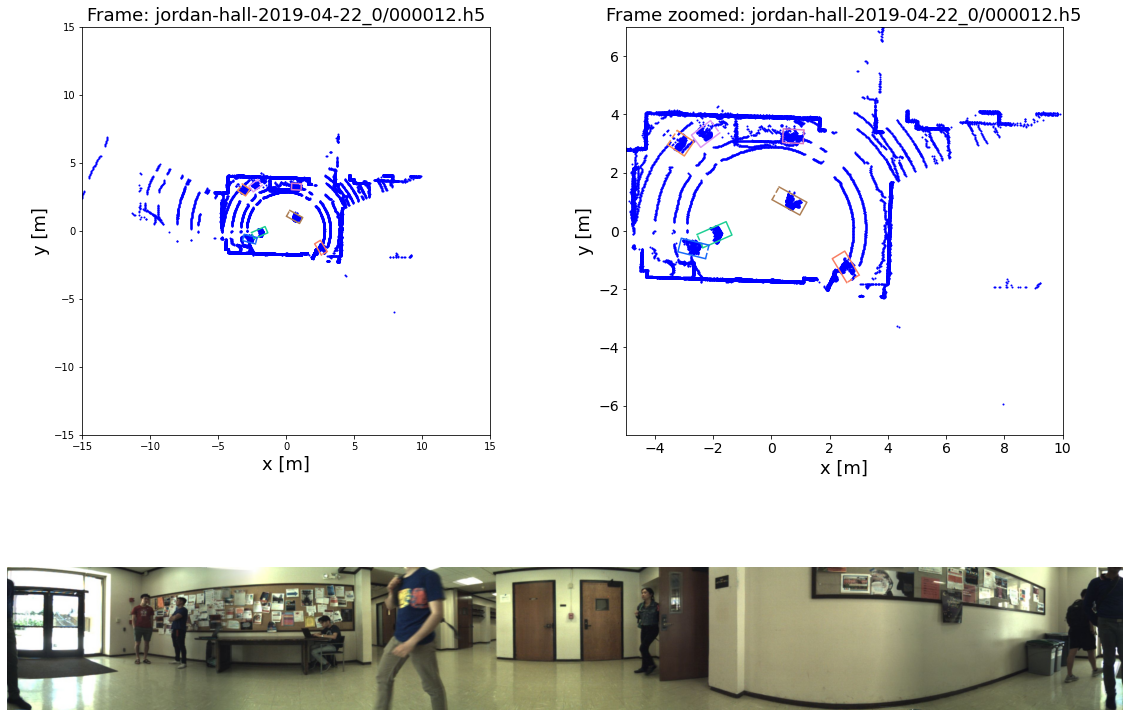

In [37]:
_plot_sequence(pts, gt_boxes, f,image=img, save_fig=True)

In [101]:
# fig_pts = visualize_pts(pts, fig=None, show_intensity=True)
fig=None
fig_dets = V.draw_scenes(pts, gt_boxes=gt_boxes,ref_boxes=None, ref_scores=None, ref_labels=None)


In [102]:
fig_dets

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03\xe8\x00\x00\x02X\x08\x02\x00\x00\x00~|[r\x00\x00…

In [45]:
import pandas as pd
def draw_point_cloud(data, ax, title, axes=['x', 'y', 'z'], axes_limits=None, xlim3d=None, ylim3d=None, zlim3d=None, point_eliminations=None):
        no_points = data.shape[0]
        point_size = 10**(3- int(np.log10(no_points))) # Adjust point size based on point cloud size
        
        if data.shape[1] == 4: # If point cloud is XYZI format (I = intensity)
            im = ax.scatter(*np.transpose(data[axes].to_numpy()), s = point_size, c=data['intensity'], cmap='viridis')
            if point_eliminations is not None: 
                ax.scatter(*np.transpose(point_eliminations[axes].to_numpy()), s = point_size, c='r', alpha = 0.7)

        elif data.shape[1] == 3:   # If point cloud is XYZ format 
            im = ax.scatter(*np.transpose(data[axes].to_numpy()), s = point_size, c='b', alpha = 0.3)
            if point_eliminations is not None: 
                ax.scatter(*np.transpose(point_eliminations[axes].to_numpy()), s = point_size, c='r', alpha = 0.7)

        ax.set_xlabel('{} axis'.format(axes[0]), fontsize=16)
        ax.set_ylabel('{} axis'.format(axes[1]), fontsize=16)
        
        if not axes_limits:
            x_max, x_min = np.max(data.x), np.min(data.x)
            y_max, y_min = np.max(data.y), np.min(data.y)
            z_max, z_min = np.max(data.z), np.min(data.z)
            
            axes_limits = [
                [x_min, x_max], # X axis range
                [y_min, y_max], # Y axis range
                [z_min, z_max]   # Z axis range
            ]
        
        if len(axes) > 2: # 3-D plot
            ax.set_xlim3d(axes_limits[0])
            ax.set_ylim3d(axes_limits[1])
            ax.set_zlim3d(axes_limits[2])
            ax.set_zlabel('{} axis'.format(axes[2]), fontsize=16)
            
        else: # 2-D plot
            ax.set_xlim(*axes_limits[0])
            ax.set_ylim(*axes_limits[1])
        
        # User specified limits
        if xlim3d!=None:
            ax.set_xlim3d(xlim3d)
        if ylim3d!=None:
            ax.set_ylim3d(ylim3d)
        if zlim3d!=None:
            ax.set_zlim3d(zlim3d)
        
        ax.set_title(title, fontsize=18)
        return im 

def show_projections(raw_data, dimensions=None, savefig=False, filename=None, point_eliminations=None): 
    """
    [summary]

    Args:
        raw_data (pandas DataFrame): the raw data loaded from rosbags to a dataframe
        dimensions (list): containing the column names (string) of the dataframe 
                           (namely x,y,z), if 'intensity' is included, points are colored 
                           according to their intensity value
        savefig (bool, default=False)
    """
    if dimensions is not None: 
        data = raw_data[dimensions]
    else: 
        data = pd.DataFrame(raw_data, columns=['x', 'y', 'z', 'intensity'])

    if point_eliminations is not None:
        point_eliminations = point_eliminations[dimensions]
    fig, ax3 = plt.subplots(1, 3, figsize=(20, 10)) # plots in 3 columns
    # f, ax3 = plt.subplots(3, 1, figsize=(12, 25)) if plots in 1 column 

    x_max, x_min = np.max(data.x), np.min(data.x)
    y_max, y_min = np.max(data.y), np.min(data.y)
    z_max, z_min = np.max(data.z), np.min(data.z)

    if point_eliminations is not None: 
        x_max, x_min = np.max(list(data.x) +  list(point_eliminations.x)), np.min(list(data.x) + list(point_eliminations.x))
        y_max, y_min = np.max(list(data.y) + list(point_eliminations.y)), np.min(list(data.y) + list(point_eliminations.y))
        z_max, z_min = np.max(list(data.z) + list(point_eliminations.z)), np.min(list(data.z) + list(point_eliminations.z))
            
        
    axes_limits = [
        [x_min, x_max], # X axis range
        [y_min, y_max], # Y axis range
        [z_min, z_max]   # Z axis range
    ]

    im1 = draw_point_cloud(data,
            ax3[0], 
            'XZ projection (Y = 0)', 
            axes=['x', 'z'], # X and Z axes,
            axes_limits=[axes_limits[0], axes_limits[2]],
            point_eliminations=point_eliminations
        )

    im2 = draw_point_cloud(data,
            ax3[1], 
            'XY projection (Z = 0)', 
            axes=['x', 'y'], # X and Y axes
            axes_limits=[axes_limits[0], axes_limits[1]],
            point_eliminations=point_eliminations
        )

    im3 = draw_point_cloud(data,
            ax3[2], 
            'YZ projection (X = 0)', 
            axes=['y', 'z'], # Y and Z axes
            axes_limits=[axes_limits[1], axes_limits[2]],
            point_eliminations=point_eliminations
        )
    if data.shape[1] == 4: 
        fig.colorbar(ax3[2].collections[0], ax=ax3[2])

    fig.suptitle('Projections of LiDAR pointcloud data', fontsize=18)
    if savefig: 
        if filename: 
            plot_dir = os.path.dirname(os.path.abspath(__file__))
            plot_dir = os.path.join(plot_dir, "../../plots/") + str(filename) + '.png'
            plt.savefig(plot_dir)  
        else: 
            print("Did not save figure. Add filename in arguments to be able to save figure.")
    plt.show()

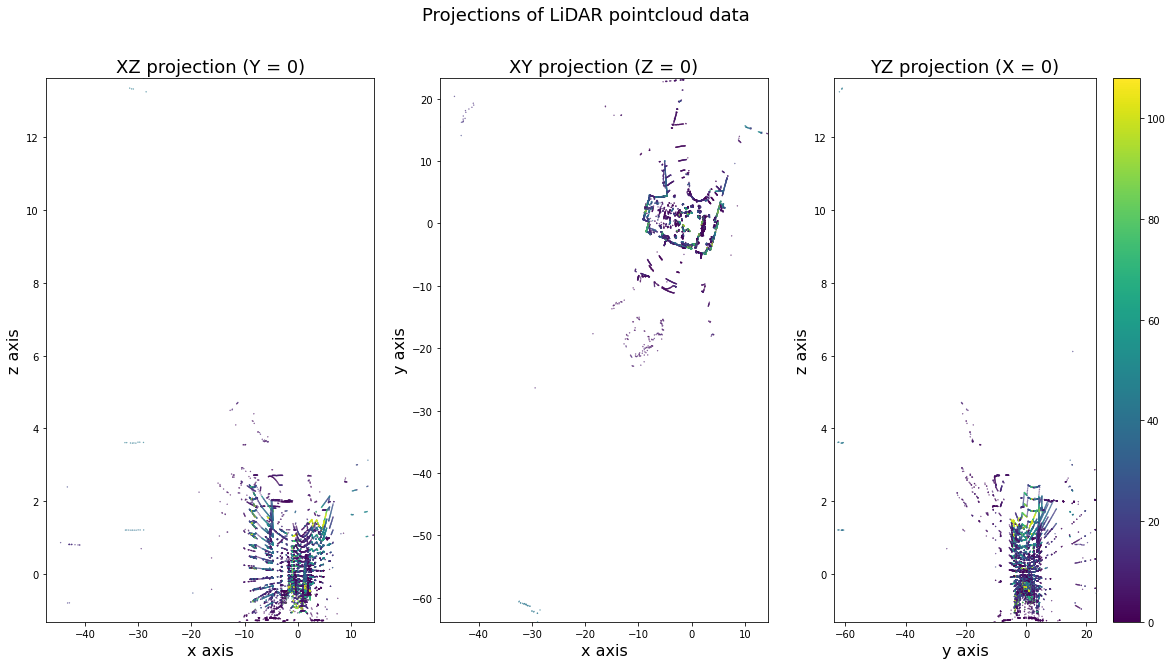

In [155]:
show_projections(pts)

# Test

In [262]:
test_path = '../../DEBUG/'
file = os.path.join(test_path, 'points_2.txt')
split_dir = '../../data/jrdb/train.txt'
current_samples = [x.strip() for x in open(split_dir).readlines()]# if 'svl-meeting-gates' in x.strip()] 

In [55]:
points = np.loadtxt(file)
print(points.shape)
diff = np.split(points, np.where(np.diff(points[:,0]))[0]+1)
# batch size = 3
pc1 = diff[0][:,1:]
pc2 = diff[1][:,1:]
pc3 = diff[2][:,1:]

(49152, 5)


batch_dict['frame_id'] = array([ 8265, 20317,  2835])    

In [53]:
f = DATA_PATH + current_samples[14157]
pts = load_pc_data(f)
print(pts.shape)
fig_pts = visualize_pts(pts, fig=None, show_intensity=True)
fig_pts

Loading data from: /hdd/master_lara_data/JRDB/cvgl/group/jrdb/data/train_dataset/pointclouds/hdf5/upper_velodyne/memorial-court-2019-03-16_0/000261.h5
(32112, 4)


Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02X\x00\x00\x02X\x08\x02\x00\x00\x001\x04\x0f\x8b\x…

In [61]:
pc_show = pc1
# pc_show[:, 1] = -pc_show[:, 1]
fig = visualize_pts(pc_show)#, show_intensity=True)
print(pc_show.shape)
fig

(16384, 4)


Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02X\x00\x00\x02X\x08\x02\x00\x00\x001\x04\x0f\x8b\x…

In [64]:
for dim in range(0, 4): 
    print('dimension: {}'.format(dim))
    print('Mean: {}'.format(np.mean(pts[:, dim])))
    print('Min: {}, Max: {}'.format(np.min(pts[:,dim]), np.max(pts[:,dim])))

dimension: 0
Mean: 1.2972593391903022
Min: -49.06098937988281, Max: 98.50060309008742
dimension: 1
Mean: -0.05121277868644087
Min: -71.53912489595803, Max: 34.495866277725895
dimension: 2
Mean: 0.7625120721313561
Min: -2.3941351771354675, Max: 18.49725443124771
dimension: 3
Mean: 17.139667414050823
Min: 0.0, Max: 113.0


In [67]:
np.mean(np.linalg.norm(pts[:, 0:3], axis=1))

14.843533122560675

In [63]:
for dim in range(0, 4): 
    print('dimension: {}'.format(dim))
    print('Mean: {}'.format(np.mean(pc_show[:, dim])))
    print('Min: {}, Max: {}'.format(np.min(pc_show[:,dim]), np.max(pc_show[:,dim])))

dimension: 0
Mean: -3.801031665057298
Min: -35.30058288574219, Max: 19.99334716796875
dimension: 1
Mean: -1.8138640725270676
Min: -49.97467041015625, Max: 48.2539176940918
dimension: 2
Mean: -2.1060059446712177e+33
Min: -4.465593334243191e+37, Max: 4.465593334243191e+37
dimension: 3
Mean: 15.15933918007795
Min: -1.704049825668335, Max: 113.0


In [66]:
np.mean(np.linalg.norm(pc_show[:, 0:3], axis=1))

1.0004770542662316e+34